In [6]:
library(tidyverse)

library(grid)
library(gridExtra)
library(patchwork)

source("../evaluation_utils/plots_eda.R")
source("../evaluation_utils/evaluation_funcs.R")

In [7]:
cbPalette <- c("#CC79A7", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00")

# Checks on the 1st repetition only

## Load data

In [17]:
data_path <- "../evaluation_data/simulated_rotation/"

before_correction <- list()
central_corrected <- list()
fed_corrected <- list()
metadata <- list()

run_number <- 2

for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced")){

    before_correction[[mode]] <- read.csv(
        paste0(data_path, mode, "/before/intermediate/", run_number, "_intensities_data.tsv"), sep = "\t", header = TRUE, check.names = F)
    central_corrected[[mode]] <- read.csv(
        paste0(data_path, mode, "/after/runs/", run_number, "_R_corrected.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)

    # before_correction[[mode]] <- read.csv(paste0(data_path, mode, "/all_intensities.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)
    before_correction[[mode]] <- before_correction[[mode]] %>% column_to_rownames("rowname")
    
    metadata[[mode]] <- read.csv(paste0(data_path, mode, "/all_metadata.tsv"), sep = "\t", header = TRUE, row.names = 1)

    # metadata[[mode]]$file <- rownames(metadata[[mode]])
    rownames(metadata[[mode]]) <- metadata[[mode]]$file
    metadata[[mode]]$condition <- as.factor(metadata[[mode]]$condition )
    metadata[[mode]]$lab <- as.factor(metadata[[mode]]$lab)

    # order the columns in intensity dataframes
    before_correction[[mode]] <- before_correction[[mode]][, rownames(metadata[[mode]])]
    central_corrected[[mode]] <- central_corrected[[mode]][rownames(before_correction[[mode]]), rownames(metadata[[mode]])]

    cat(mode, "before correction:", nrow(before_correction[[mode]]), "rows\n")
    cat(mode, "after R correction:", nrow(central_corrected[[mode]]), "rows\n")
    cat(mode, "metadata:", nrow(metadata[[mode]]), "rows\n\n")
}

balanced before correction: 6000 rows
balanced after R correction: 6000 rows
balanced metadata: 600 rows

mild_imbalanced before correction: 6000 rows
mild_imbalanced after R correction: 6000 rows
mild_imbalanced metadata: 600 rows

strong_imbalanced before correction: 6000 rows
strong_imbalanced after R correction: 6000 rows
strong_imbalanced metadata: 600 rows



## Diagnostic plots

In [18]:
# supress warnings
options(warn=-1)

In [19]:
plot_pca_uncorrected <- list()
plot_pca_corrected <- list()

layouts <- list()

for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced")){

    before_with_zeros <- before_correction[[mode]]
    before_with_zeros[is.na(before_with_zeros)] <- 0
    after_with_zeros <- central_corrected[[mode]]
    after_with_zeros[is.na(after_with_zeros)] <- 0

    plot_pca_uncorrected[[mode]] <- pca_plot(
        before_with_zeros, metadata[[mode]],
        title = paste("Before correction"),
        quantitative_col_name = "file", 
        col_col = "condition", shape_col="lab", show_legend=T, cbPalette=c("#a70a66", "#2a609d"),
        point_size = 1
        )

    plot_pca_corrected[[mode]] <- pca_plot(
        after_with_zeros, metadata[[mode]],
        title = paste("After correction"),
        quantitative_col_name = "file", 
        col_col = "condition", shape_col="lab", show_legend=F, cbPalette=c("#a70a66", "#2a609d"),
        point_size = 1
        )

    layout <- plot_pca_uncorrected[[mode]] /
              plot_pca_corrected[[mode]]
    layout <- layout + plot_annotation(paste0("PCA plots, simulated ", mode))
}



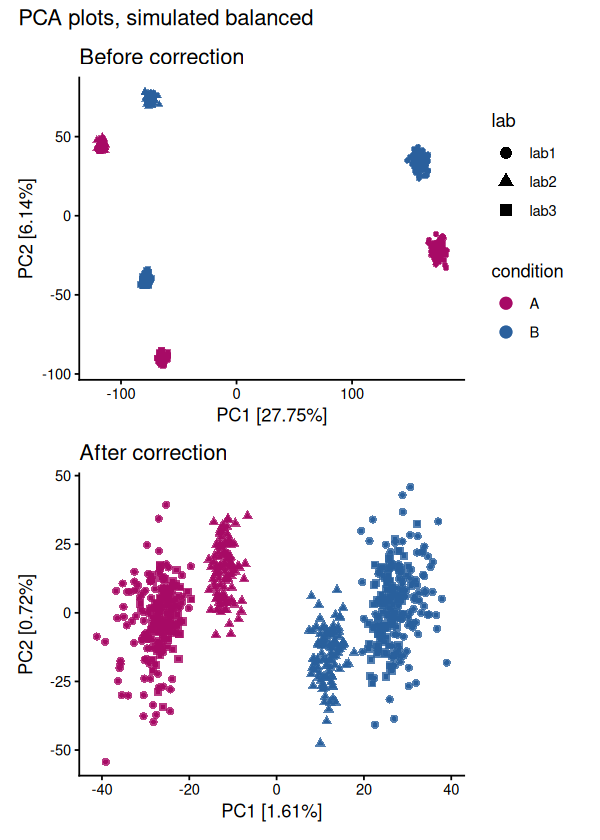

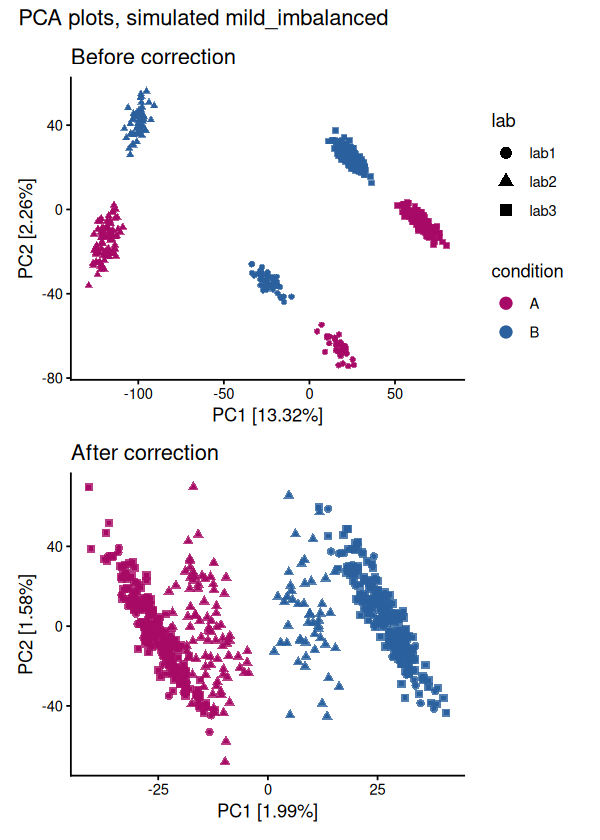

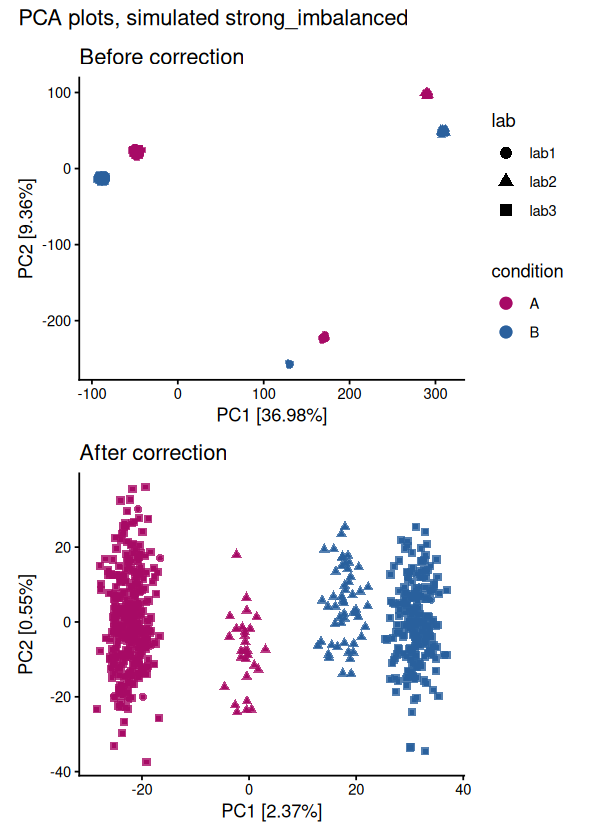

In [20]:
options(repr.plot.width=5, repr.plot.height=7, dpi=600)

for (mode in c("balanced", "mild_imbalanced", "strong_imbalanced")) {
    plot_corrected_one <- plot_pca_corrected[[mode]] + 
        geom_point(size = 2, alpha = 0.8)

    plot_uncorrected_one <- plot_pca_uncorrected[[mode]] + 
        geom_point(size = 1.5, alpha = 0.7)


    # change the legend marker size (the kegend was added using theme(legend.position = "none"))
    plot_uncorrected_one <- plot_uncorrected_one +
        guides(
            colour = guide_legend(
            override.aes = list(size = 3)   # ← larger filled circles
            ),
            shape  = guide_legend(
            override.aes = list(size = 3)   # ← larger shape symbols
            )
        ) 

    layout <- plot_uncorrected_one /
              plot_corrected_one

    layout <- layout + plot_annotation(paste0("PCA plots, simulated ", mode))
    print(layout)
}

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_violin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_violin()`).”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_violin()`).”


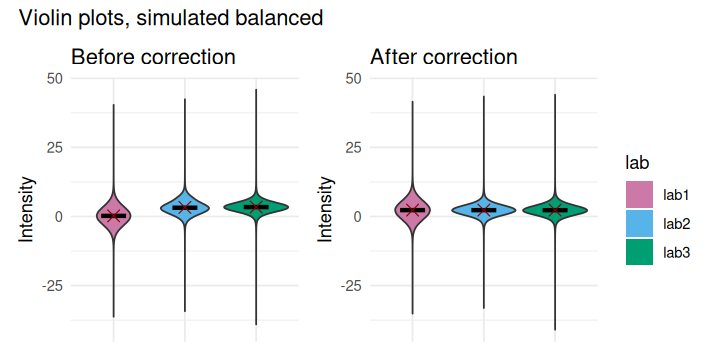

Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_violin()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_violin()`).”


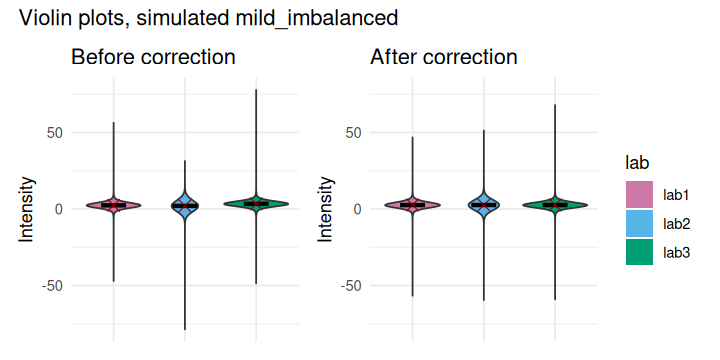

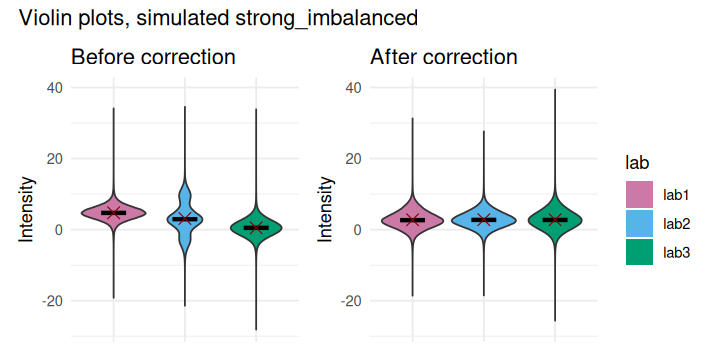

In [28]:
violins_uncorrected <- list()
violins_fed <- list()

for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced")){

    # # Determine the shared Y-axis limits
    y_min <- min(before_correction[[mode]], central_corrected[[mode]], na.rm = TRUE)
    y_max <- max(before_correction[[mode]], central_corrected[[mode]], na.rm = TRUE)
    y_limits <- c(y_min, y_max)

    violins_uncorrected[[mode]] <- boxplot_plot_groupped(
        before_correction[[mode]], metadata[[mode]], 
        title = paste("Before correction"),
        quantitativeColumnName = "file",
        color_col = "lab", remove_xnames = T, show_legend=F, y_limits = y_limits, cbPalette = cbPalette)
    
    violins_fed[[mode]] <- boxplot_plot_groupped(
        central_corrected[[mode]], metadata[[mode]], 
        title = paste("After correction"),
        quantitativeColumnName = "file",
        color_col = "lab", remove_xnames = T, show_legend=T, y_limits = y_limits, cbPalette = cbPalette)

    options(repr.plot.width=6, repr.plot.height=3)
    layout <- violins_uncorrected[[mode]] | violins_fed[[mode]]
    layout <- layout + plot_annotation(paste0("Violin plots, simulated ", mode))
    print(layout)
}

In [ ]:
# # pca and violins in one
# layout <- (plot_pca_uncorrected[["balanced"]] + plot_pca_corrected[["balanced"]]) /
#           (violins_uncorrected[["balanced"]] + violins_central[["balanced"]]) /
#             (plot_pca_uncorrected[["mild_imbalanced"]] + plot_pca_corrected[["mild_imbalanced"]]) /
#             (violins_uncorrected[["mild_imbalanced"]] + violins_central[["mild_imbalanced"]]) /
#             (plot_pca_uncorrected[["strong_imbalanced"]] + plot_pca_corrected[["strong_imbalanced"]]) /
#             (violins_uncorrected[["strong_imbalanced"]] + violins_central[["strong_imbalanced"]])

# options(repr.plot.width=10, repr.plot.height=18)
# layout 

##  Linear model per variable

Following batch effect correction, the percentage of variance explained by the condition should be greater than the batch.

In [29]:
library(variancePartition)

In [30]:
getOption("warn")
options(warn = 0) 

[1] 0

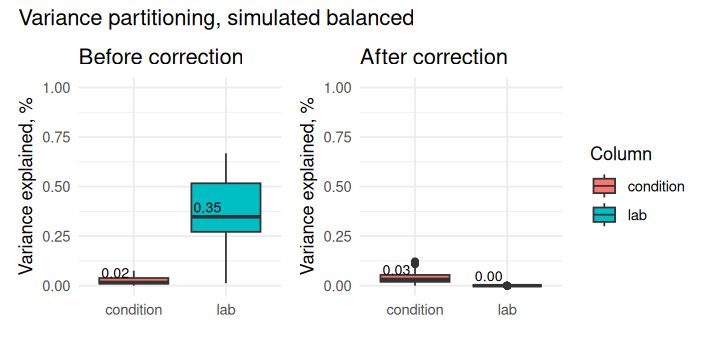

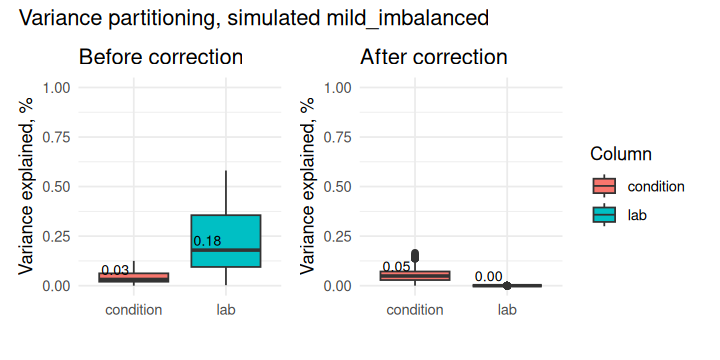

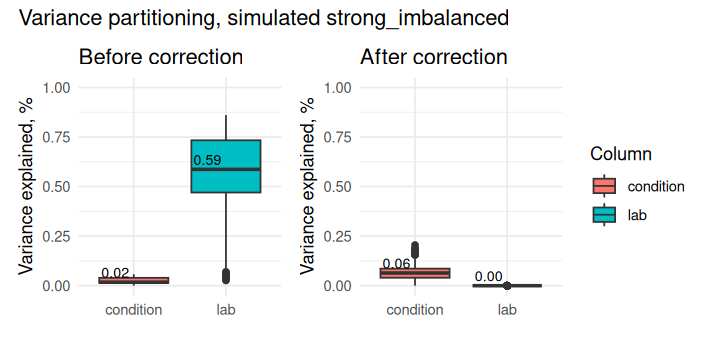

In [32]:
form <- ~ condition + lab

y_limits_values <- list(
    "balanced" = 0.51,
    "mild_imbalanced" = 0.62,
    "strong_imbalanced" = 0.6
)

lmpv_plot_uncorrected <- list()
lmpv_plot_fed <- list()

for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced")){

    before_with_zeros <- before_correction[[mode]][1:2400,]
    before_with_zeros[is.na(before_with_zeros)] <- 0
    after_with_zeros <- central_corrected[[mode]][1:2400,]
    after_with_zeros[is.na(after_with_zeros)] <- 0

    lmpv_plot_uncorrected[[mode]] <- lmpv_plot(before_with_zeros, metadata[[mode]], 
        paste("Before correction"), show_legend=F, 
        # max_yval = y_limits_values[[mode]],
        form = form)
    lmpv_plot_fed[[mode]] <- lmpv_plot(after_with_zeros, metadata[[mode]], 
        paste("After correction"), 
        # max_yval = y_limits_values[[mode]],
        form = form)

    layout <- lmpv_plot_uncorrected[[mode]] |  lmpv_plot_fed[[mode]]
    layout <- layout + plot_annotation(paste0("Variance partitioning, simulated ", mode))
    options(repr.plot.width=6, repr.plot.height=3)
    print(layout)
}


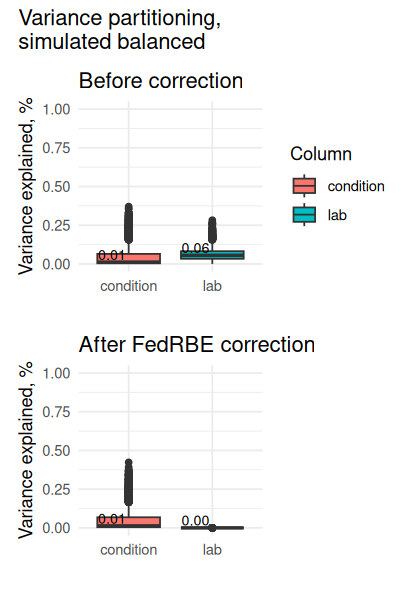

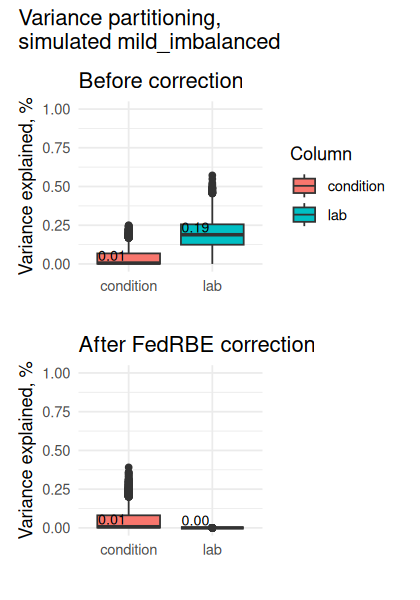

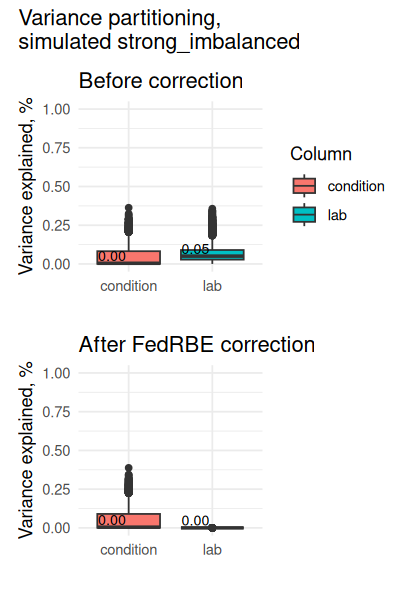

In [ ]:

# lmpv_plot_uncorrected <- list()
# lmpv_plot_fed <- list()

# for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced")){

#     before_with_zeros <- before_correction[[mode]]
#     before_with_zeros[is.na(before_with_zeros)] <- 0
#     after_with_zeros <- fed_corrected[[mode]]
#     after_with_zeros[is.na(after_with_zeros)] <- 0

#     lmpv_plot_uncorrected[[mode]] <- lmpv_plot(before_with_zeros, metadata[[mode]], 
#         paste("Before correction"), show_legend=T, 
#         # max_yval = y_limits_values[[mode]],
#         form = form)
#     lmpv_plot_fed[[mode]] <- lmpv_plot(after_with_zeros, metadata[[mode]], 
#         paste("After FedRBE correction"), , show_legend=F, 
#         # max_yval = y_limits_values[[mode]],
#         form = form)

#     layout <- lmpv_plot_uncorrected[[mode]] /
#               lmpv_plot_fed[[mode]]
#     layout <- layout + plot_annotation(paste0("Variance partitioning, \nsimulated ", mode))
#     options(repr.plot.width=3.5, repr.plot.height=5)
#     print(layout)
# }


In [ ]:
# layout <- (lmpv_plot_uncorrected[["balanced"]] + lmpv_plots_corrected[["balanced"]]) /
#             (lmpv_plot_uncorrected[["mild_imbalanced"]] + lmpv_plots_corrected[["mild_imbalanced"]]) /
#             (lmpv_plot_uncorrected[["strong_imbalanced"]] + lmpv_plots_corrected[["strong_imbalanced"]])

# options(repr.plot.width=10, repr.plot.height=10)
# layout

## Errors

In [ ]:
# for (mode in c("balanced", "mild_imbalanced", "strong_imbalanced")){
#     print(paste("Mode:", mode))
#     differences <- calculated_differences(central_corrected[[mode]], fed_corrected[[mode]])
#     cat("Min difference:", differences[2], "\n")
#     cat("Mean difference:", differences[3], "\n")
#     cat("Max difference:", differences[1], "\n")
    
#     cat("\n")
# }

[1] "Mode: balanced"
Min difference: 0 
Mean difference: 2.551808e-15 
Max difference: 5.329071e-14 

[1] "Mode: mild_imbalanced"
Min difference: 0 
Mean difference: 3.443313e-15 
Max difference: 5.684342e-14 

[1] "Mode: strong_imbalanced"
Min difference: 0 
Mean difference: 2.42912e-15 
Max difference: 5.506706e-14 



# Kmeans clustering before and after batch effect correction

In [40]:
# Kmeans clustering after batch effect correction

total_runs <- 15

for (mode in c("balanced", "mild_imbalanced", "strong_imbalanced")) {
  for (run_number in c(1:total_runs)) {
    print(paste("Mode:", mode, "Run number:", run_number))
    metadata_mode <- metadata[[mode]]

    #########################
    # After correction
    #########################
    data_for_clustering <- read.csv(
        paste0(data_path, mode, "/after/runs/", run_number, "_R_corrected.tsv"), 
        sep = "\t", header = TRUE, row.names = 1, check.names = F
      )

    for (k in c(2, 3)) {
        set.seed(123)
        kmeans_result <- kmeans(t(data_for_clustering), centers = k, nstart = 25)
        cluster_assignments <- kmeans_result$cluster
        
        # create a data frame with the cluster assignments
        clustering_res <- data.frame(cluster_assignment = cluster_assignments) %>%
          rownames_to_column("file") %>%
          rename(!!paste0("Cor_CtrlKm_", k, "clusters") := cluster_assignment) 
          
        metadata_mode <- metadata_mode %>%
          full_join(clustering_res, by = "file")   
    }


    #########################
    # Before correction
    #########################
    data_for_clustering <- read.csv(
        paste0(data_path, mode, "/before/intermediate/", run_number, "_intensities_data.tsv"), 
        sep = "\t", header = TRUE, row.names = 1, check.names = F
      )

    for (k in c(2, 3)) {
        set.seed(123)
        kmeans_result <- kmeans(t(data_for_clustering), centers = k, nstart = 25)
        cluster_assignments <- kmeans_result$cluster
        
        # create a data frame with the cluster assignments
        clustering_res <- data.frame(cluster_assignment = cluster_assignments) %>%
          rownames_to_column("file") %>%
          rename(!!paste0("Before_CtrlKm_", k, "clusters") := cluster_assignment) 
          
        metadata_mode <- metadata_mode %>%
          full_join(clustering_res, by = "file")   
    }

    #################################
    # Save results to files
    #################################

    # save resulting metadata to a file
    path_to_write <- paste0(
      "../evaluation_data/simulated_rotation/", mode, "/after/kmeans_res/runs/"
    )
    if (!dir.exists(path_to_write)) {
        dir.create(path_to_write, recursive = TRUE)
    }
    write_delim(
      metadata_mode,
      file = file.path(path_to_write, paste0(run_number, "_metadata_cntrl_kmeans_res.tsv")),
      delim = "\t"
    )
  }
}
    

[1] "Mode: balanced Run number: 1"
[1] "Mode: balanced Run number: 2"
[1] "Mode: balanced Run number: 3"
[1] "Mode: balanced Run number: 4"
[1] "Mode: balanced Run number: 5"
[1] "Mode: balanced Run number: 6"
[1] "Mode: balanced Run number: 7"
[1] "Mode: balanced Run number: 8"
[1] "Mode: balanced Run number: 9"
[1] "Mode: balanced Run number: 10"
[1] "Mode: balanced Run number: 11"
[1] "Mode: balanced Run number: 12"
[1] "Mode: balanced Run number: 13"
[1] "Mode: balanced Run number: 14"
[1] "Mode: balanced Run number: 15"
[1] "Mode: mild_imbalanced Run number: 1"
[1] "Mode: mild_imbalanced Run number: 2"
[1] "Mode: mild_imbalanced Run number: 3"
[1] "Mode: mild_imbalanced Run number: 4"
[1] "Mode: mild_imbalanced Run number: 5"
[1] "Mode: mild_imbalanced Run number: 6"
[1] "Mode: mild_imbalanced Run number: 7"
[1] "Mode: mild_imbalanced Run number: 8"
[1] "Mode: mild_imbalanced Run number: 9"
[1] "Mode: mild_imbalanced Run number: 10"
[1] "Mode: mild_imbalanced Run number: 11"
[1] "

In [ ]:
# # save corrected data for strong_imbalanced mode to be used in fed kmeans evaluation
# for (mode in c(
#   "balanced", "mild_imbalanced",
#   "strong_imbalanced")){
#   # check if "before_corrected" folder exists, if not, create it
#   path_to_write <- paste0("../evaluation_data/simulated_rotation/", mode, "/before_corrected/")
#   if (!dir.exists(path_to_write)) {
#       dir.create(path_to_write, recursive = TRUE)
#   }

#   # save as intensities.tsv. and design.tsv files
#   for (lab in c("lab1", "lab2", "lab3")) {
#       path_to_write <- paste0("../evaluation_data/simulated_rotation/", mode, "/before_corrected/", lab, "/")
      
#       if (!dir.exists(path_to_write)) {
#           dir.create(path_to_write, recursive = TRUE)
#       }
            
#       design_data <- metadata[[mode]] %>%
#         filter(lab == lab) 
#       lab_data <- fed_corrected[[mode]][, design_data$file]

#       write_delim(
#         as.data.frame(lab_data) %>% rownames_to_column("rowname"),
#         file = file.path(path_to_write, "intensities.tsv"),
#         delim = "\t"
#       )

#       write_delim(
#         design_data,
#         file = file.path(path_to_write, "design.tsv"),
#         delim = "\t"
#       )
#   }
# }

# Session info

In [41]:
print(sessionInfo())

R version 4.4.3 (2025-02-28)
Platform: x86_64-conda-linux-gnu
Running under: Ubuntu 24.04.2 LTS

Matrix products: default
BLAS/LAPACK: /home/yuliya-cosybio/miniforge3/envs/fedRBE/lib/libopenblasp-r0.3.30.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] variancePartition_1.36.2 BiocParallel_1.40.0      limma_3.62.1            
 [4] viridis_0.6.5            viridisLite_0.4.2        ggsci_4.2.0             
 [7] umap_0.2.10.0            patchwork_1.3.2      